## *This is the most up-to-date plotting script*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
hep.style.use("CMS")
from coffea import util
import itertools
import os, sys
import glob
import copy
from scipy.optimize import curve_fit
import uproot

sys.path.append('../python/')
from functions import loadCoffeaFile, getLabelMap, getCoffeaFilenames, plotBackgroundEstimate, getHist, lumi


In [2]:
# make image save file directories #

In [3]:
directories = [
    'images/png/closureTest/2016all',
    'images/png/closureTest/2016APV',
    'images/png/closureTest/2016',
    'images/png/closureTest/2017',
    'images/png/closureTest/2018',
    'images/pdf/closureTest/2016all',
    'images/pdf/closureTest/2016APV',
    'images/pdf/closureTest/2016',
    'images/pdf/closureTest/2017',
    'images/pdf/closureTest/2018',
    
    'images/png/ttbarmass/2016all',
    'images/png/ttbarmass/2016APV',
    'images/png/ttbarmass/2016',
    'images/png/ttbarmass/2017',
    'images/png/ttbarmass/2018',
    'images/pdf/ttbarmass/2016all',
    'images/pdf/ttbarmass/2016APV',
    'images/pdf/ttbarmass/2016',
    'images/pdf/ttbarmass/2017',
    'images/pdf/ttbarmass/2018',
]


for path in directories:
    if not os.path.exists(path):
        os.makedirs(path)

## analysis categories

In [4]:
IOV = '2016'

# analysis categories #

label_dict = loadCoffeaFile()['analysisCategories']

label_to_int_dict = {label: i for i, label in label_dict.items()}

signal_cats = [ i for label, i in label_to_int_dict.items() if '2t' in label]
pretag_cats = [ i for label, i in label_to_int_dict.items() if 'pre' in label]
antitag_cats = [ i for label, i in label_to_int_dict.items() if 'at' in label]


## scale factors

In [5]:
IOVs = ['2016']

lumi = {
    "2016APV": 19800.,
    "2016": 16120., #35920 - 19800
    "2016all": 35920,
    "2017": 41530.,
    "2018": 59740.
}

t_BR = 0.6741
ttbar_BR = 0.4544 #PDG 2019
ttbar_xs1 = 831.76 * (0.09210) #pb For ttbar mass from 700 to 1000
ttbar_xs2 = 831.76 * (0.02474) #pb For ttbar mass from 1000 to Inf
toptag_sf = 0.9
toptag_kf = 1.0 #0.7
qcd_xs = 13700000.0 #pb From https://cms-gen-dev.cern.ch/xsdb

zprime_xs = {
    '1000': 2.222,
    '1500': 0.387,
    '2000': 0.09428,
    '2500': 0.0279,
    '3000': 0.009327,
    '3500': 0.003507,
    '4000': 0.001484,
    '4500': 0.0007087,
    '5000': 0.0003801,
}



RSGluon_xs = {
    '1000': 21.03,
    '1500': 3.656,
    '2000': 0.9417,
    '2500': 0.3039,
    '3000': 0.1163,
    '3500': 0.05138,
    '4000': 0.02556,
    '4500': 0.01422,
    '5000': 0.008631,
}






# transfer function

In [6]:
# fit N events from CR to N events from SR


# loose to fail | pretag to antitag

def rlf(x, mt, p0, p1):
    
    return x*(p0 + p1 * mt)


# pass to loose | signal to pretag

def rtl(x, mt, mtt, p2, p3, p4, p5):
    
    return x * (p2 + p3 * mt + p4 * mt * mt) * (p5 * mtt) 
    

In [7]:
mtt_vs_mt = getHist('mtt_vs_mt', 'JetHT', False, '2016', sum_axes=[], integrate_axes={'systematic':'nominal'})
tt_mtt_vs_mt = getHist('mtt_vs_mt', 'TTbar', False, '2016', sum_axes=[], integrate_axes={'systematic':'nominal'})


# get 2d histograms of mt and mtt
h2dsr = mtt_vs_mt[{'anacat':signal_cats}][{'anacat':sum}]
h2dcr = mtt_vs_mt[{'anacat':antitag_cats}][{'anacat':sum}]
h2dpr = mtt_vs_mt[{'anacat':pretag_cats}][{'anacat':sum}]


# N events in signal, antitag (control), and pretag region
Nsr = h2dsr.values()
Ncr = h2dcr.values()
Npr = h2dpr.values()


# 2d array of mt and mtt bins
bins_mt = h2dsr.axes['jetmass'].edges[:-1]
bins_mtt = h2dsr.axes['ttbarmass'].edges[:-1]
mt, mtt = np.meshgrid(bins_mt, bins_mtt)

# flatten arrays for fitting
f_mt  =  mt.flatten()
f_mtt = mtt.flatten()
f_nsr = Nsr.flatten()
f_ncr = Ncr.flatten()
f_npr = Npr.flatten()


/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


## fit the transfer functions

In [8]:
# loose to fail | pretag to antitag


y = np.where(f_ncr > 0, f_npr/f_ncr, 0)

popt, pcov = curve_fit(lambda x, p0, p1: rlf(x, f_mt, p0, p1), 
                       f_ncr, 
                       f_npr, 
                       p0=[1,1])


p0, p1 = popt

f_rlf = rlf(np.ones_like(Ncr), mt, p0, p1)



# pass to loose | signal to pretag


y = np.where(f_npr > 0, f_nsr/f_npr, 0)





popt, pcov = curve_fit(lambda x, p2, p3, p4, p5: rtl(x, f_mt, f_mtt, p2, p3, p4, p5), 
                       f_npr,
                       f_nsr,
                       p0=[1,1,1,1], bounds=[-10,10])


p2, p3, p4, p5 = popt

f_rtl = rtl(np.ones_like(Ncr), mt, mtt, p2, p3, p4, p5)


/tmp/ipykernel_6225/4214148893.py:4: RuntimeWarning: divide by zero encountered in divide
  y = np.where(f_ncr > 0, f_npr/f_ncr, 0)
/tmp/ipykernel_6225/4214148893.py:4: RuntimeWarning: invalid value encountered in divide
  y = np.where(f_ncr > 0, f_npr/f_ncr, 0)
/tmp/ipykernel_6225/4214148893.py:21: RuntimeWarning: invalid value encountered in divide
  y = np.where(f_npr > 0, f_nsr/f_npr, 0)


## fit the transfer function by analysis category

In [9]:
transfer_functions = {}
cats = ['0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd']
cat_labels = ['cen0b', 'fwd0b', 'cen1b', 'fwd1b', 'cen2b', 'fwd2b']

mtt_vs_mt = getHist('mtt_vs_mt', 'JetHT', False, '2016', sum_axes=[], integrate_axes={})


for cat in cats:

    signal_cat  = label_to_int_dict['2t'+cat]
    pretag_cat  = label_to_int_dict['pret'+cat]
    antitag_cat = label_to_int_dict['at'+cat]


    # get 2d histograms of mt and mtt
    h2dsr = mtt_vs_mt[{'anacat':signal_cat, 'systematic':'nominal'}]
    h2dcr = mtt_vs_mt[{'anacat':antitag_cat, 'systematic':'nominal'}]
    h2dpr = mtt_vs_mt[{'anacat':pretag_cat, 'systematic':'nominal'}]


    # N events in signal, antitag (control), and pretag region
    Nsr = h2dsr.values()
    Ncr = h2dcr.values()
    Npr = h2dpr.values()


    # 2d array of mt and mtt bins
    bins_mt = h2dsr.axes['jetmass'].edges[:-1]
    bins_mtt = h2dsr.axes['ttbarmass'].edges[:-1]
    mtt, mt = np.meshgrid(bins_mtt, bins_mt)

    # flatten arrays for fitting
    f_mt  =  mt.flatten()
    f_mtt = mtt.flatten()
    f_nsr = Nsr.flatten()
    f_ncr = Ncr.flatten()
    f_npr = Npr.flatten()
    
    
    
    
    
    # loose to fail | pretag to antitag


    y = np.where(f_ncr > 0, f_npr/f_ncr, 0)

    popt, pcov = curve_fit(lambda x, p0, p1: rlf(x, f_mt, p0, p1), 
                           f_ncr, 
                           f_npr, 
                           p0=[1,1])


    p0, p1 = popt

    f_rlf = rlf(np.ones_like(Ncr), mt, p0, p1)



    # pass to loose | signal to pretag


    y = np.where(f_npr > 0, f_nsr/f_npr, 0)





    popt, pcov = curve_fit(lambda x, p2, p3, p4, p5: rtl(x, f_mt, f_mtt, p2, p3, p4, p5), 
                           f_npr,
                           f_nsr,
                           p0=[1,1,1,1], bounds=[-10,10])


    p2, p3, p4, p5 = popt

    f_rtl = rtl(np.ones_like(Ncr), mt, mtt, p2, p3, p4, p5)
    
    
    
    transfer_functions[cat] = f_rlf


/tmp/ipykernel_6225/3411617610.py:46: RuntimeWarning: divide by zero encountered in divide
  y = np.where(f_ncr > 0, f_npr/f_ncr, 0)
/tmp/ipykernel_6225/3411617610.py:46: RuntimeWarning: invalid value encountered in divide
  y = np.where(f_ncr > 0, f_npr/f_ncr, 0)
/tmp/ipykernel_6225/3411617610.py:63: RuntimeWarning: invalid value encountered in divide
  y = np.where(f_npr > 0, f_nsr/f_npr, 0)


## plot data and background

/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: invalid value encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: invalid value encountered in divide
  ufunc(


saving  images/png/closureTest/2016/closuretest_inclusive.png
saving  images/pdf/closureTest/2016/closuretest_inclusive.pdf


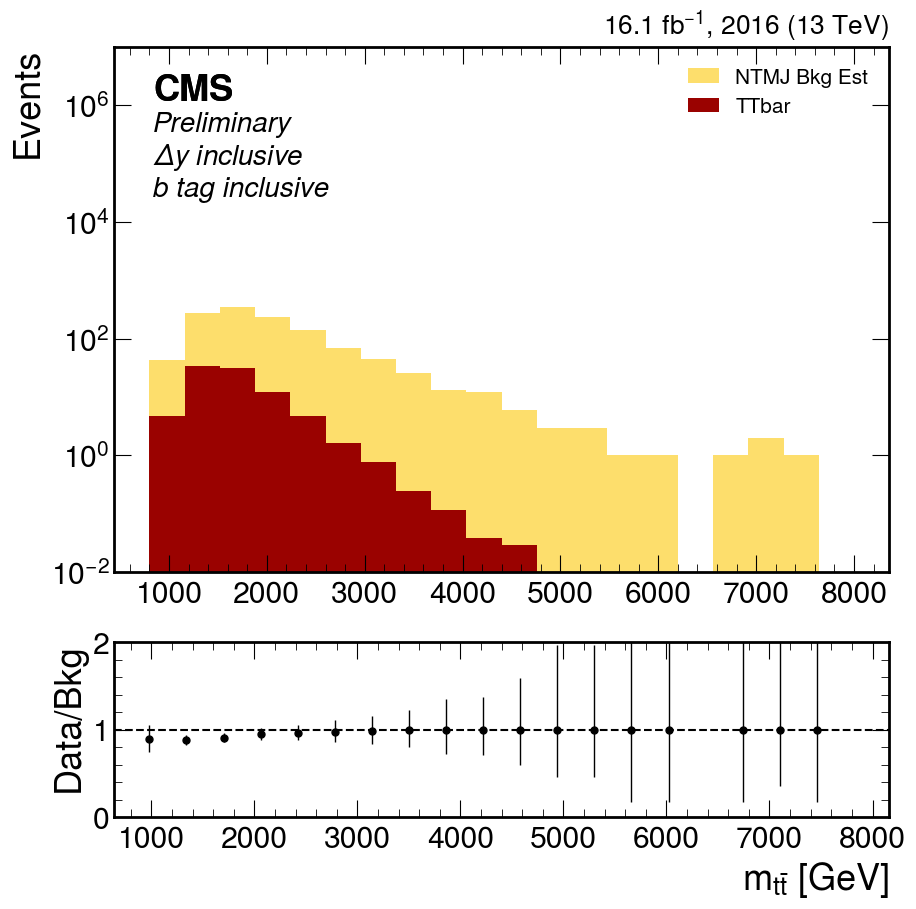

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

IOV = '2016'

httbar = getHist('ttbarmass', 'TTbar', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':signal_cats,'systematic':'nominal'})
hdata  = getHist('ttbarmass', 'JetHT', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':signal_cats,'systematic':'nominal'})


httbar = getHist('mtt_vs_mt', 'TTbar', False, IOV,
                 sum_axes=['anacat'],
                 integrate_axes={'anacat':signal_cats,'systematic':'nominal'})[{'jetmass':sum}]
hdata = getHist('mtt_vs_mt', 'JetHT', False, IOV,
                 sum_axes=['anacat'],
                 integrate_axes={'anacat':signal_cats,'systematic':'nominal'})[{'jetmass':sum}]



h_mtt_mt = getHist('mtt_vs_mt', 'JetHT', False, IOV, sum_axes=['anacat'],
                   integrate_axes={'anacat':signal_cats,'systematic':'nominal'})#

h_mtt_mt = h_mtt_mt
hntmj_2d = h_mtt_mt#*f_rtl
hntmj = hntmj_2d[{'jetmass':sum}]

hbkg = hntmj + httbar


# hep.histplot(hdata, histtype='errorbar', color='k', ax=ax1, label='Data')
hep.histplot(hbkg, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='TTbar', ax=ax1)


text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+'\n'+r'b tag inclusive'
hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi['2016']/1000.), year='2016', loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)




ax1.set_yscale('log')
ax1.set_ylim(1e-2,1e7)

ax1.set_ylabel('Events')

ratio_plot = hdata / hbkg.values()


hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(0,2)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')
ax2.set_xlabel(ax1.get_xlabel())
ax1.set_xlabel('')


ax1.legend(loc=1, fontsize=15)


imagefile = f'images/png/closureTest/{IOV}/closuretest_inclusive.png'

plt.savefig(imagefile)
plt.savefig(imagefile.replace('png','pdf'))
print('saving ', imagefile)
print('saving ', imagefile.replace('png','pdf'))



## mass window 100 to 200 GeV

In [11]:
qcdfile = util.load('../outputs/QCD_2016_test.coffea')
qcd_sf = lumi['2016'] * qcd_xs / qcdfile['cutflow']['sumw']
qcd_sf

21535684119859.402

In [12]:
qcdfile['cutflow']['all events']

656352

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


saving  images/png/closureTest/2016/closuretest_inclusive.png
saving  images/pdf/closureTest/2016/closuretest_inclusive.pdf


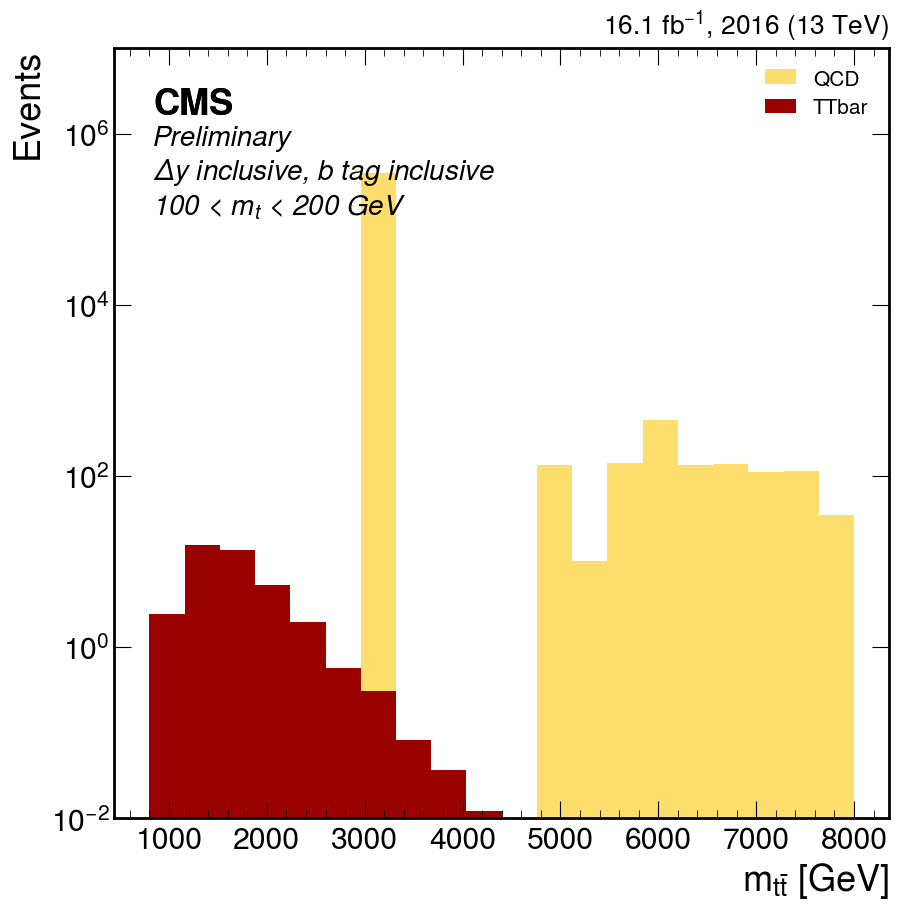

In [13]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])


fig, ax1 = plt.subplots()#nrows=2, height_ratios=[3, 1])

IOV = '2016'



httbar2d = getHist('mtt_vs_mt', 'TTbar', False, IOV,
                 sum_axes=['anacat'],
                 integrate_axes={'anacat':signal_cats,'systematic':'nominal'})

hdata2d = getHist('mtt_vs_mt', 'JetHT', False, IOV,
                 sum_axes=['anacat'],
                 integrate_axes={'anacat':signal_cats,'systematic':'nominal'})



hqcd2d = qcdfile['mtt_vs_mt'][{'anacat':signal_cats, 'systematic':'nominal'}][{'anacat':sum}]

httbar = httbar2d[100j, :] + httbar2d[125j, :] + httbar2d[150j, :] + httbar2d[200j, :]
hdata  = hdata2d[100j, :] + hdata2d[125j, :] + hdata2d[150j, :] + hdata2d[200j, :]


hqcd  = (httbar2d[4, :] + httbar2d[5, :] + httbar2d[6, :] + httbar2d[7, :])
hqcd  = (hqcd2d[4, :] + hqcd2d[5, :] + hqcd2d[6, :] + hqcd2d[7, :])*qcd_sf


h_mtt_mt = getHist('mtt_vs_mt', 'JetHT', False, IOV, sum_axes=['anacat'],
                   integrate_axes={'anacat':signal_cats,'systematic':'nominal'})#

hntmj = hqcd #h_mtt_mt[100j, :] + h_mtt_mt[125j, :] + h_mtt_mt[150j, :] + h_mtt_mt[200j, :]

hbkg = hntmj + httbar


# hep.histplot(hdata, histtype='errorbar', color='k', ax=ax1, label='Data')
hep.histplot(hqcd+httbar, histtype='fill', color='xkcd:pale gold', label='QCD', ax=ax1)
hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='TTbar', ax=ax1)


text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b tag inclusive' + '\n' + r'100 < $m_{t}$ < 200 GeV'
hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi['2016']/1000.), year='2016', loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)




ax1.set_yscale('log')
ax1.set_ylim(1e-2,1e7)

ax1.set_ylabel('Events')

ratio_plot = hdata / hbkg.values()


# hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
# ax2.set_ylim(0,2)
# ax2.axhline(1, color='black', ls='--')
# ax2.set_ylabel('Data/Bkg')
# ax2.set_xlabel(ax1.get_xlabel())
# ax1.set_xlabel('')


ax1.legend(loc=1, fontsize=15)


imagefile = f'images/png/closureTest/{IOV}/closuretest_inclusive.png'

plt.savefig(imagefile)
plt.savefig(imagefile.replace('png','pdf'))
print('saving ', imagefile)
print('saving ', imagefile.replace('png','pdf'))



### get signal files

In [14]:
RSGluon1000file = util.load('../outputs/RSGluon1000_2016.coffea')
RSGluon1500file = util.load('../outputs/RSGluon1500_2016.coffea')
RSGluon2000file = util.load('../outputs/RSGluon2000_2016.coffea')
RSGluon2500file = util.load('../outputs/RSGluon2500_2016.coffea')
RSGluon3000file = util.load('../outputs/RSGluon3000_2016.coffea')
RSGluon3500file = util.load('../outputs/RSGluon3500_2016.coffea')
RSGluon4000file = util.load('../outputs/RSGluon4000_2016.coffea')
RSGluon4500file = util.load('../outputs/RSGluon4500_2016.coffea')
RSGluon5000file = util.load('../outputs/RSGluon5000_2016.coffea')

## plot $m_{t\bar{t}}$

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: invalid value encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: invalid value encountered in divide
  ufunc(


saving  images/png/ttbarmass/2016/ttbarmass_inclusive.png
saving  images/pdf/ttbarmass/2016/ttbarmass_inclusive.pdf


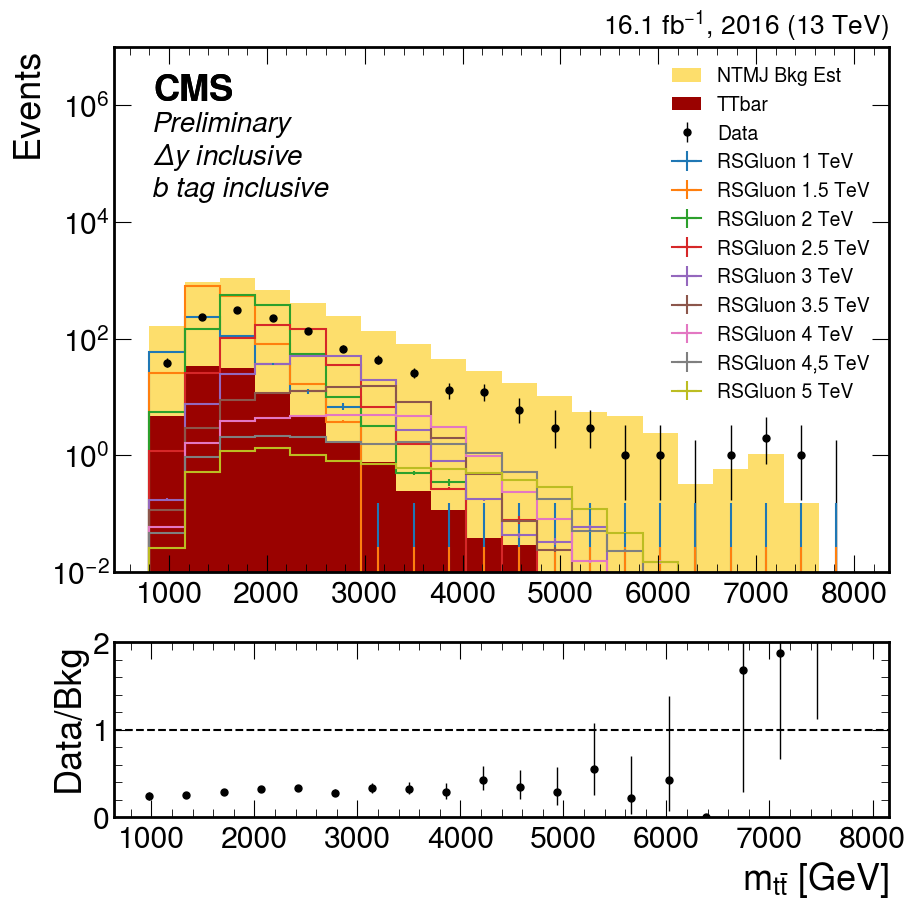

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])



IOV = '2016'

httbar = getHist('ttbarmass', 'TTbar', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':signal_cats,'systematic':'nominal'})
hdata  = getHist('ttbarmass', 'JetHT', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':signal_cats,'systematic':'nominal'})


httbar = getHist('mtt_vs_mt', 'TTbar', False, IOV,
                 sum_axes=['anacat'],
                 integrate_axes={'anacat':signal_cats,'systematic':'nominal'})[{'jetmass':sum}]
hdata = getHist('mtt_vs_mt', 'JetHT', False, IOV,
                 sum_axes=['anacat'],
                 integrate_axes={'anacat':signal_cats,'systematic':'nominal'})[{'jetmass':sum}]



h_mtt_mt = getHist('mtt_vs_mt', 'JetHT', False, IOV, 
                   sum_axes=['anacat'], 
                   integrate_axes={'anacat':pretag_cats, 'systematic':'nominal'})



hntmj_2d = h_mtt_mt * f_rlf # * f_rtl
hntmj = hntmj_2d[{'jetmass':sum}]


hbkg = hntmj + httbar





hRSGluon1000 = RSGluon1000file['mtt_vs_mt'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}][{'jetmass':sum}] * lumi['2016'] * RSGluon_xs['1000'] / RSGluon1000file['cutflow']['sumw']
hRSGluon1500 = RSGluon1500file['mtt_vs_mt'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}][{'jetmass':sum}] * lumi['2016'] * RSGluon_xs['1500'] / RSGluon1500file['cutflow']['sumw']
hRSGluon2000 = RSGluon2000file['mtt_vs_mt'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}][{'jetmass':sum}] * lumi['2016'] * RSGluon_xs['2000'] / RSGluon2000file['cutflow']['sumw']
hRSGluon2500 = RSGluon2500file['mtt_vs_mt'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}][{'jetmass':sum}] * lumi['2016'] * RSGluon_xs['2500'] / RSGluon2500file['cutflow']['sumw']
hRSGluon3000 = RSGluon3000file['mtt_vs_mt'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}][{'jetmass':sum}] * lumi['2016'] * RSGluon_xs['3000'] / RSGluon3000file['cutflow']['sumw']
hRSGluon3500 = RSGluon3500file['mtt_vs_mt'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}][{'jetmass':sum}] * lumi['2016'] * RSGluon_xs['3500'] / RSGluon3500file['cutflow']['sumw']
hRSGluon4000 = RSGluon4000file['mtt_vs_mt'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}][{'jetmass':sum}] * lumi['2016'] * RSGluon_xs['4000'] / RSGluon4000file['cutflow']['sumw']
hRSGluon4500 = RSGluon4500file['mtt_vs_mt'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}][{'jetmass':sum}] * lumi['2016'] * RSGluon_xs['4500'] / RSGluon4500file['cutflow']['sumw']
hRSGluon5000 = RSGluon5000file['mtt_vs_mt'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}][{'jetmass':sum}] * lumi['2016'] * RSGluon_xs['5000'] / RSGluon5000file['cutflow']['sumw']



hep.histplot(hdata, histtype='errorbar', color='k', ax=ax1, label='Data')
hep.histplot(hbkg, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='TTbar', ax=ax1)
hep.histplot(hRSGluon1000, histtype='step', color='C0', label='RSGluon 1 TeV', ax=ax1)
hep.histplot(hRSGluon1500, histtype='step', color='C1', label='RSGluon 1.5 TeV', ax=ax1)
hep.histplot(hRSGluon2000, histtype='step', color='C2', label='RSGluon 2 TeV', ax=ax1)
hep.histplot(hRSGluon2500, histtype='step', color='C3', label='RSGluon 2.5 TeV', ax=ax1)
hep.histplot(hRSGluon3000, histtype='step', color='C4', label='RSGluon 3 TeV', ax=ax1)
hep.histplot(hRSGluon3500, histtype='step', color='C5', label='RSGluon 3.5 TeV', ax=ax1)
hep.histplot(hRSGluon4000, histtype='step', color='C6', label='RSGluon 4 TeV', ax=ax1)
hep.histplot(hRSGluon4500, histtype='step', color='C7', label='RSGluon 4,5 TeV', ax=ax1)
hep.histplot(hRSGluon5000, histtype='step', color='C8', label='RSGluon 5 TeV', ax=ax1)





ax1.set_yscale('log')
ax1.set_ylim(1e-2,1e7)

ax1.set_ylabel('Events')

ratio_plot = hdata / hbkg.values()



text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+'\n'+r'b tag inclusive'
hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi['2016']/1000.), year='2016', loc=2, fontsize=20, ax=ax1)
hep.cms.text(text, loc=2, fontsize=20, ax=ax1)



hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(0,2)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')
ax2.set_xlabel(ax1.get_xlabel())
ax1.set_xlabel('')


ax1.legend(loc=1, fontsize=14)


imagefile = f'images/png/ttbarmass/{IOV}/ttbarmass_inclusive.png'

plt.savefig(imagefile)
plt.savefig(imagefile.replace('png','pdf'))
print('saving ', imagefile)
print('saving ', imagefile.replace('png','pdf'))

## loop through analysis categories and systematics

In [16]:
# cats = ['0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd']
# cat_labels = ['cen0b', 'fwd0b', 'cen1b', 'fwd1b', 'cen2b', 'fwd2b']
# systematics = ['nominal', 'pileup', 'prefiring', 'pdf']
# syst_labels = ['nominal']
# for s in systematics:
#     if not 'nominal' in s:
#         syst_labels.append(s+'Down')
#         syst_labels.append(s+'Up')

        
        
        
cats = ['0bcen']
cat_labels = ['cen0b']
systematics = ['nominal','pileup','pdf','jes','jer']
syst_labels = ['nominal']
for s in systematics:
    if not 'nominal' in s:
        syst_labels.append(s+'Down')
        syst_labels.append(s+'Up')
#         
        
cats = ['0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd']
cat_labels = ['cen0b', 'fwd0b', 'cen1b', 'fwd1b', 'cen2b', 'fwd2b']

## make root files for 2DAlphabet

### inclusive

In [75]:
fdata = uproot.recreate('TTbarAllHad16_Data.root')
fttbar = uproot.recreate('TTbarAllHad16_TTbar.root')
f1000 = uproot.recreate('TTbarAllHad16_signalRSGluon1000.root')
f1500 = uproot.recreate('TTbarAllHad16_signalRSGluon1500.root')
f2000 = uproot.recreate('TTbarAllHad16_signalRSGluon2000.root')
f2500 = uproot.recreate('TTbarAllHad16_signalRSGluon2500.root')
f3000 = uproot.recreate('TTbarAllHad16_signalRSGluon3000.root')
f3500 = uproot.recreate('TTbarAllHad16_signalRSGluon3500.root')
f4000 = uproot.recreate('TTbarAllHad16_signalRSGluon4000.root')
f4500 = uproot.recreate('TTbarAllHad16_signalRSGluon4500.root')
f5000 = uproot.recreate('TTbarAllHad16_signalRSGluon5000.root')

signal_cats  = [ i for i, label in label_dict.items() if '2t' in label]
antitag_cats = [ i for i, label in label_dict.items() if 'at' in label]

    


for syst in syst_labels:

    print('inclusive', syst)


    hRSGluon1000_pass = RSGluon1000file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['1000'] / RSGluon1000file['cutflow']['sumw']
    hRSGluon1500_pass = RSGluon1500file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['1500'] / RSGluon1500file['cutflow']['sumw']
    hRSGluon2000_pass = RSGluon2000file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['2000'] / RSGluon2000file['cutflow']['sumw']
    hRSGluon2500_pass = RSGluon2500file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['2500'] / RSGluon2500file['cutflow']['sumw']
    hRSGluon3000_pass = RSGluon3000file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['3000'] / RSGluon3000file['cutflow']['sumw']
    hRSGluon3500_pass = RSGluon3500file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['3500'] / RSGluon3500file['cutflow']['sumw']
    hRSGluon4000_pass = RSGluon4000file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['4000'] / RSGluon4000file['cutflow']['sumw']
    hRSGluon4500_pass = RSGluon4500file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['4500'] / RSGluon4500file['cutflow']['sumw']
    hRSGluon5000_pass = RSGluon5000file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['5000'] / RSGluon5000file['cutflow']['sumw']

    hRSGluon1000_fail = RSGluon1000file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['1000'] / RSGluon1000file['cutflow']['sumw']
    hRSGluon1500_fail = RSGluon1500file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['1500'] / RSGluon1500file['cutflow']['sumw']
    hRSGluon2000_fail = RSGluon2000file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['2000'] / RSGluon2000file['cutflow']['sumw']
    hRSGluon2500_fail = RSGluon2500file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['2500'] / RSGluon2500file['cutflow']['sumw']
    hRSGluon3000_fail = RSGluon3000file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['3000'] / RSGluon3000file['cutflow']['sumw']
    hRSGluon3500_fail = RSGluon3500file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['3500'] / RSGluon3500file['cutflow']['sumw']
    hRSGluon4000_fail = RSGluon4000file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['4000'] / RSGluon4000file['cutflow']['sumw']
    hRSGluon4500_fail = RSGluon4500file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['4500'] / RSGluon4500file['cutflow']['sumw']
    hRSGluon5000_fail = RSGluon5000file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}][{'anacat':sum}] * lumi['2016'] * RSGluon_xs['5000'] / RSGluon5000file['cutflow']['sumw']

    httbar_pass = getHist('mtt_vs_mt', 'TTbar', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':signal_cats, 'systematic':syst})
    httbar_fail = getHist('mtt_vs_mt', 'TTbar', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':antitag_cats, 'systematic':syst})






    if 'nominal' in syst:

        hdata_pass  = getHist('mtt_vs_mt', 'JetHT', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':signal_cats, 'systematic':'nominal'})
        hdata_fail  = getHist('mtt_vs_mt', 'JetHT', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':antitag_cats, 'systematic':'nominal'})

        fdata["MttvsMtPass"] = hdata_pass
        fdata["MttvsMtFail"] = hdata_fail

        fttbar["MttvsMtPass"] = httbar_pass
        fttbar["MttvsMtFail"] = httbar_fail


        f1000["MttvsMtPass"] = hRSGluon1000_pass
        f1500["MttvsMtPass"] = hRSGluon1500_pass
        f2000["MttvsMtPass"] = hRSGluon2000_pass
        f2500["MttvsMtPass"] = hRSGluon2500_pass
        f3000["MttvsMtPass"] = hRSGluon3000_pass
        f3500["MttvsMtPass"] = hRSGluon3500_pass
        f4000["MttvsMtPass"] = hRSGluon4000_pass
        f4500["MttvsMtPass"] = hRSGluon4500_pass
        f5000["MttvsMtPass"] = hRSGluon5000_pass

        f1000["MttvsMtFail"] = hRSGluon1000_fail
        f1500["MttvsMtFail"] = hRSGluon1500_fail
        f2000["MttvsMtFail"] = hRSGluon2000_fail
        f2500["MttvsMtFail"] = hRSGluon2500_fail
        f3000["MttvsMtFail"] = hRSGluon3000_fail
        f3500["MttvsMtFail"] = hRSGluon3500_fail
        f4000["MttvsMtFail"] = hRSGluon4000_fail
        f4500["MttvsMtFail"] = hRSGluon4500_fail
        f5000["MttvsMtFail"] = hRSGluon5000_fail

    else:

        systname = syst.upper()[:-2] + 'up' if 'Up' in syst else syst.upper()[:-4] + 'down'


#             fdata["MttvsMtPass"+systname] = hdata_pass
#             fdata["MttvsMtFail"+systname] = hdata_fail

        fttbar["MttvsMtPass"+systname] = httbar_pass
        fttbar["MttvsMtFail"+systname] = httbar_fail

        f1000["MttvsMtPass"+systname] = hRSGluon1000_pass
        f1500["MttvsMtPass"+systname] = hRSGluon1500_pass
        f2000["MttvsMtPass"+systname] = hRSGluon2000_pass
        f2500["MttvsMtPass"+systname] = hRSGluon2500_pass
        f3000["MttvsMtPass"+systname] = hRSGluon3000_pass
        f3500["MttvsMtPass"+systname] = hRSGluon3500_pass
        f4000["MttvsMtPass"+systname] = hRSGluon4000_pass
        f4500["MttvsMtPass"+systname] = hRSGluon4500_pass
        f5000["MttvsMtPass"+systname] = hRSGluon5000_pass

        f1000["MttvsMtFail"+systname] = hRSGluon1000_fail
        f1500["MttvsMtFail"+systname] = hRSGluon1500_fail
        f2000["MttvsMtFail"+systname] = hRSGluon2000_fail
        f2500["MttvsMtFail"+systname] = hRSGluon2500_fail
        f3000["MttvsMtFail"+systname] = hRSGluon3000_fail
        f3500["MttvsMtFail"+systname] = hRSGluon3500_fail
        f4000["MttvsMtFail"+systname] = hRSGluon4000_fail
        f4500["MttvsMtFail"+systname] = hRSGluon4500_fail
        f5000["MttvsMtFail"+systname] = hRSGluon5000_fail









fdata.close()
fttbar.close()
f1000.close()
f1500.close()
f2000.close()
f2500.close()
f3000.close()
f3500.close()
f4000.close()
f4500.close()
f5000.close()

inclusive nominal
inclusive pileupDown
inclusive pileupUp
inclusive pdfDown
inclusive pdfUp
inclusive jesDown
inclusive jesUp
inclusive jerDown
inclusive jerUp


### analysis categories

In [17]:
fdata = uproot.recreate('TTbarAllHad16_Data.root')
fttbar = uproot.recreate('TTbarAllHad16_TTbar.root')
f1000 = uproot.recreate('TTbarAllHad16_signalRSGluon1000.root')
f1500 = uproot.recreate('TTbarAllHad16_signalRSGluon1500.root')
f2000 = uproot.recreate('TTbarAllHad16_signalRSGluon2000.root')
f2500 = uproot.recreate('TTbarAllHad16_signalRSGluon2500.root')
f3000 = uproot.recreate('TTbarAllHad16_signalRSGluon3000.root')
f3500 = uproot.recreate('TTbarAllHad16_signalRSGluon3500.root')
f4000 = uproot.recreate('TTbarAllHad16_signalRSGluon4000.root')
f4500 = uproot.recreate('TTbarAllHad16_signalRSGluon4500.root')
f5000 = uproot.recreate('TTbarAllHad16_signalRSGluon5000.root')


for cat, catname in zip(cats, cat_labels):
    
    signal_cats  = label_to_int_dict['2t'+cat]
    pretag_cats  = label_to_int_dict['pret'+cat]
    antitag_cats = label_to_int_dict['at'+cat]
    
    print(signal_cats)
    
    
    for syst in syst_labels:
        
        print(cat, syst)
        
     
        hRSGluon1000_pass = RSGluon1000file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['1000'] / RSGluon1000file['cutflow']['sumw']
        hRSGluon1500_pass = RSGluon1500file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['1500'] / RSGluon1500file['cutflow']['sumw']
        hRSGluon2000_pass = RSGluon2000file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['2000'] / RSGluon2000file['cutflow']['sumw']
        hRSGluon2500_pass = RSGluon2500file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['2500'] / RSGluon2500file['cutflow']['sumw']
        hRSGluon3000_pass = RSGluon3000file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['3000'] / RSGluon3000file['cutflow']['sumw']
        hRSGluon3500_pass = RSGluon3500file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['3500'] / RSGluon3500file['cutflow']['sumw']
        hRSGluon4000_pass = RSGluon4000file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['4000'] / RSGluon4000file['cutflow']['sumw']
        hRSGluon4500_pass = RSGluon4500file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['4500'] / RSGluon4500file['cutflow']['sumw']
        hRSGluon5000_pass = RSGluon5000file['mtt_vs_mt'][{'anacat':signal_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['5000'] / RSGluon5000file['cutflow']['sumw']

        hRSGluon1000_fail = RSGluon1000file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['1000'] / RSGluon1000file['cutflow']['sumw']
        hRSGluon1500_fail = RSGluon1500file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['1500'] / RSGluon1500file['cutflow']['sumw']
        hRSGluon2000_fail = RSGluon2000file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['2000'] / RSGluon2000file['cutflow']['sumw']
        hRSGluon2500_fail = RSGluon2500file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['2500'] / RSGluon2500file['cutflow']['sumw']
        hRSGluon3000_fail = RSGluon3000file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['3000'] / RSGluon3000file['cutflow']['sumw']
        hRSGluon3500_fail = RSGluon3500file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['3500'] / RSGluon3500file['cutflow']['sumw']
        hRSGluon4000_fail = RSGluon4000file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['4000'] / RSGluon4000file['cutflow']['sumw']
        hRSGluon4500_fail = RSGluon4500file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['4500'] / RSGluon4500file['cutflow']['sumw']
        hRSGluon5000_fail = RSGluon5000file['mtt_vs_mt'][{'anacat':antitag_cats,'systematic':syst}] * lumi['2016'] * RSGluon_xs['5000'] / RSGluon5000file['cutflow']['sumw']

        httbar_pass = getHist('mtt_vs_mt', 'TTbar', False, IOV, sum_axes=[], integrate_axes={'anacat':signal_cats, 'systematic':syst})
        httbar_fail = getHist('mtt_vs_mt', 'TTbar', False, IOV, sum_axes=[], integrate_axes={'anacat':antitag_cats, 'systematic':syst})
        
        
            
        
        
        
        if 'nominal' in syst:
                        
            hdata_pass  = getHist('mtt_vs_mt', 'JetHT', False, IOV, sum_axes=[], integrate_axes={'anacat':signal_cats, 'systematic':'nominal'})
            hdata_fail  = getHist('mtt_vs_mt', 'JetHT', False, IOV, sum_axes=[], integrate_axes={'anacat':antitag_cats, 'systematic':'nominal'})
        
            fdata["MttvsMt"+catname+"Pass"] = hdata_pass
            fdata["MttvsMt"+catname+"Fail"] = hdata_fail
            
            fttbar["MttvsMt"+catname+"Pass"] = httbar_pass
            fttbar["MttvsMt"+catname+"Fail"] = httbar_fail
            
            
            f1000["MttvsMt"+catname+"Pass"] = hRSGluon1000_pass
            f1500["MttvsMt"+catname+"Pass"] = hRSGluon1500_pass
            f2000["MttvsMt"+catname+"Pass"] = hRSGluon2000_pass
            f2500["MttvsMt"+catname+"Pass"] = hRSGluon2500_pass
            f3000["MttvsMt"+catname+"Pass"] = hRSGluon3000_pass
            f3500["MttvsMt"+catname+"Pass"] = hRSGluon3500_pass
            f4000["MttvsMt"+catname+"Pass"] = hRSGluon4000_pass
            f4500["MttvsMt"+catname+"Pass"] = hRSGluon4500_pass
            f5000["MttvsMt"+catname+"Pass"] = hRSGluon5000_pass
            
            f1000["MttvsMt"+catname+"Fail"] = hRSGluon1000_fail
            f1500["MttvsMt"+catname+"Fail"] = hRSGluon1500_fail
            f2000["MttvsMt"+catname+"Fail"] = hRSGluon2000_fail
            f2500["MttvsMt"+catname+"Fail"] = hRSGluon2500_fail
            f3000["MttvsMt"+catname+"Fail"] = hRSGluon3000_fail
            f3500["MttvsMt"+catname+"Fail"] = hRSGluon3500_fail
            f4000["MttvsMt"+catname+"Fail"] = hRSGluon4000_fail
            f4500["MttvsMt"+catname+"Fail"] = hRSGluon4500_fail
            f5000["MttvsMt"+catname+"Fail"] = hRSGluon5000_fail
            
        else:
                        
            systname = syst.upper()[:-2] + 'up' if 'Up' in syst else syst.upper()[:-4] + 'down'

            
#             fdata["MttvsMt"+catname+"Pass"+systname] = hdata_pass
#             fdata["MttvsMt"+catname+"Fail"+systname] = hdata_fail

            fttbar["MttvsMt"+catname+"Pass"+systname] = httbar_pass
            fttbar["MttvsMt"+catname+"Fail"+systname] = httbar_fail
        
            f1000["MttvsMt"+catname+"Pass"+systname] = hRSGluon1000_pass
            f1500["MttvsMt"+catname+"Pass"+systname] = hRSGluon1500_pass
            f2000["MttvsMt"+catname+"Pass"+systname] = hRSGluon2000_pass
            f2500["MttvsMt"+catname+"Pass"+systname] = hRSGluon2500_pass
            f3000["MttvsMt"+catname+"Pass"+systname] = hRSGluon3000_pass
            f3500["MttvsMt"+catname+"Pass"+systname] = hRSGluon3500_pass
            f4000["MttvsMt"+catname+"Pass"+systname] = hRSGluon4000_pass
            f4500["MttvsMt"+catname+"Pass"+systname] = hRSGluon4500_pass
            f5000["MttvsMt"+catname+"Pass"+systname] = hRSGluon5000_pass
            
            f1000["MttvsMt"+catname+"Fail"+systname] = hRSGluon1000_fail
            f1500["MttvsMt"+catname+"Fail"+systname] = hRSGluon1500_fail
            f2000["MttvsMt"+catname+"Fail"+systname] = hRSGluon2000_fail
            f2500["MttvsMt"+catname+"Fail"+systname] = hRSGluon2500_fail
            f3000["MttvsMt"+catname+"Fail"+systname] = hRSGluon3000_fail
            f3500["MttvsMt"+catname+"Fail"+systname] = hRSGluon3500_fail
            f4000["MttvsMt"+catname+"Fail"+systname] = hRSGluon4000_fail
            f4500["MttvsMt"+catname+"Fail"+systname] = hRSGluon4500_fail
            f5000["MttvsMt"+catname+"Fail"+systname] = hRSGluon5000_fail


                        
            
        
        

        
        
fdata.close()
fttbar.close()
f1000.close()
f1500.close()
f2000.close()
f2500.close()
f3000.close()
f3500.close()
f4000.close()
f4500.close()
f5000.close()

12
0bcen nominal
0bcen pileupDown
0bcen pileupUp
0bcen pdfDown
0bcen pdfUp
0bcen jesDown
0bcen jesUp
0bcen jerDown
0bcen jerUp
13
0bfwd nominal
0bfwd pileupDown
0bfwd pileupUp
0bfwd pdfDown
0bfwd pdfUp
0bfwd jesDown
0bfwd jesUp
0bfwd jerDown
0bfwd jerUp
14
1bcen nominal
1bcen pileupDown
1bcen pileupUp


KeyboardInterrupt: 

In [18]:
lumi['2016'] * RSGluon_xs['2000'] / RSGluon2000file['cutflow']['sumw']

0.003795051

In [19]:
httbar_pass = getHist('mtt_vs_mt', 'TTbar', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':signal_cats, 'systematic':'nominal'})


ValueError: The axis name anacat could not be found

In [ ]:
print([int(b) for b in httbar_pass.axes['ttbarmass'].edges][:-1])

### closure test

In [20]:
# f = uproot.recreate('regions.root')

# for cat, catname in zip(cats, cat_labels):
#     for syst in syst_labels:
        
        
#         fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])


#         signal_cat = label_to_int_dict['2t'+cat]
#         pretag_cat = label_to_int_dict['pret'+cat]
        
        
        
#         httbar = getHist('ttbarmass', 'TTbar', False, IOV, 
#                          sum_axes=[], 
#                          integrate_axes={'anacat':signal_cat,
#                                          'systematic':syst,
#                                         }
#                         )
        
        
#         hdata = getHist('ttbarmass', 'JetHT', False, IOV, 
#                          sum_axes=[], 
#                          integrate_axes={'anacat':signal_cat,
#                                          'systematic':syst,
#                                         }
#                         )
#         h_mtt_mt = getHist('mtt_vs_mt', 'JetHT', False, IOV, 
#                            sum_axes=[], 
#                            integrate_axes={'anacat':pretag_cat,
#                                           'systematic':syst,
#                                           })
        
        
# #         hntmj_2d = h_mtt_mt * f_rlf
#         hntmj_2d = h_mtt_mt * transfer_functions[cat]
        
#         hntmj = hntmj_2d[{'jetmass':sum}]


#         hbkg = httbar + hntmj
        

#         hep.histplot(hdata, histtype='errorbar', color='k', ax=ax1, label='Data')
#         hep.histplot(hbkg, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
#         hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='TTbar', ax=ax1)
    
        
#         ax1.set_ylim(1e-2,1e6)
#         ax1.set_yscale('log')
        
        
#         ratio_plot = hdata / hbkg.values()


#         hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
#         ax2.set_ylim(0,2)
#         ax2.axhline(1, color='black', ls='--')
#         ax2.set_ylabel('Data/Bkg')
#         ax2.set_xlabel(ax1.get_xlabel())
#         ax1.set_xlabel('')

        
#         dytext = ''
#         if 'cen' in cat:
#             dytext = r'$\Delta y$ < 1.0'
#         elif 'fwd' in cat:
#             dytext = r'$\Delta y$ > 1.0'

#         btext = ''
#         if '0b' in cat:
#             btext = '0 b-tags'
#         elif '1b' in cat:
#             btext = '1 b-tag'
#         elif '2b' in cat:
#             btext = '2 b-tags'
        
#         text = f'Preliminary\n{btext}, {dytext} \n'
#         hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi['2016']/1000.), year='2016', loc=2, fontsize=20, ax=ax1)
#         hep.cms.text(text, loc=2, fontsize=20, ax=ax1)
        
        
#         ax1.legend(loc=1, fontsize=14)
        
#         plt.plot()
        
        
        
#         imagefile = f'images/png/closureTest/{IOV}/closuretest_{catname}_{syst}.png'

#         plt.savefig(imagefile)
#         plt.savefig(imagefile.replace('png','pdf'))
#         print('saving ', imagefile)
#         print('saving ', imagefile.replace('png','pdf'))


        
        
        
        

## plot ttbarmass histogram and save files 

In [21]:
# f = uproot.recreate('regions.root')

# for cat, catname in zip(cats, cat_labels):
#     for syst in syst_labels:
        
        
#         fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])


#         signal_cat = label_to_int_dict['2t'+cat]
#         pretag_cat = label_to_int_dict['pret'+cat]
        
        
        
#         httbar = getHist('ttbarmass', 'TTbar', False, IOV, 
#                          sum_axes=[], 
#                          integrate_axes={'anacat':signal_cat,
#                                          'systematic':syst,
#                                         }
#                         )
        
        
#         hdata = getHist('ttbarmass', 'JetHT', False, IOV, 
#                          sum_axes=[], 
#                          integrate_axes={'anacat':signal_cat,
#                                          'systematic':syst,
#                                         }
#                         )
#         h_mtt_mt = getHist('mtt_vs_mt', 'JetHT', False, IOV, sum_axes=['systematic'], integrate_axes={'anacat':pretag_cat})
        
        
#         hntmj_2d = h_mtt_mt * f_rlf * f_rtl
        
#         hntmj = hntmj_2d[{'jetmass':sum}]


#         hbkg = httbar + hntmj
        


#         hRSGluon1000 = RSGluon1000file['ttbarmass'][{'anacat':signal_cat,'systematic':syst}] * lumi['2016'] * RSGluon_xs['1000'] / RSGluon1000file['cutflow']['sumw']
#         hRSGluon1500 = RSGluon1500file['ttbarmass'][{'anacat':signal_cat,'systematic':syst}] * lumi['2016'] * RSGluon_xs['1500'] / RSGluon1500file['cutflow']['sumw']
#         hRSGluon2000 = RSGluon2000file['ttbarmass'][{'anacat':signal_cat,'systematic':syst}] * lumi['2016'] * RSGluon_xs['2000'] / RSGluon2000file['cutflow']['sumw']
#         hRSGluon2500 = RSGluon2500file['ttbarmass'][{'anacat':signal_cat,'systematic':syst}] * lumi['2016'] * RSGluon_xs['2500'] / RSGluon2500file['cutflow']['sumw']
#         hRSGluon3000 = RSGluon3000file['ttbarmass'][{'anacat':signal_cat,'systematic':syst}] * lumi['2016'] * RSGluon_xs['3000'] / RSGluon3000file['cutflow']['sumw']
#         hRSGluon3500 = RSGluon3500file['ttbarmass'][{'anacat':signal_cat,'systematic':syst}] * lumi['2016'] * RSGluon_xs['3500'] / RSGluon3500file['cutflow']['sumw']
#         hRSGluon4000 = RSGluon4000file['ttbarmass'][{'anacat':signal_cat,'systematic':syst}] * lumi['2016'] * RSGluon_xs['4000'] / RSGluon4000file['cutflow']['sumw']
#         hRSGluon4500 = RSGluon4500file['ttbarmass'][{'anacat':signal_cat,'systematic':syst}] * lumi['2016'] * RSGluon_xs['4500'] / RSGluon4500file['cutflow']['sumw']
#         hRSGluon5000 = RSGluon5000file['ttbarmass'][{'anacat':signal_cat,'systematic':syst}] * lumi['2016'] * RSGluon_xs['5000'] / RSGluon5000file['cutflow']['sumw']



#         hep.histplot(hdata, histtype='errorbar', color='k', ax=ax1, label='Data')
#         hep.histplot(hbkg, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
#         hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='TTbar', ax=ax1)
#         hep.histplot(hRSGluon1000, histtype='step', color='C0', label='RSGluon 1 TeV', ax=ax1)
#         hep.histplot(hRSGluon1500, histtype='step', color='C1', label='RSGluon 1.5 TeV', ax=ax1)
#         hep.histplot(hRSGluon2000, histtype='step', color='C2', label='RSGluon 2 TeV', ax=ax1)
#         hep.histplot(hRSGluon2500, histtype='step', color='C3', label='RSGluon 2.5 TeV', ax=ax1)
#         hep.histplot(hRSGluon3000, histtype='step', color='C4', label='RSGluon 3 TeV', ax=ax1)
#         hep.histplot(hRSGluon3500, histtype='step', color='C5', label='RSGluon 3.5 TeV', ax=ax1)
#         hep.histplot(hRSGluon4000, histtype='step', color='C6', label='RSGluon 4 TeV', ax=ax1)
#         hep.histplot(hRSGluon4500, histtype='step', color='C7', label='RSGluon 4,5 TeV', ax=ax1)
#         hep.histplot(hRSGluon5000, histtype='step', color='C8', label='RSGluon 5 TeV', ax=ax1)
    
        
#         ax1.set_ylim(1e-2,1e6)
#         ax1.set_yscale('log')
        
        
#         ratio_plot = hdata / hbkg.values()


#         hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
#         ax2.set_ylim(0,2)
#         ax2.axhline(1, color='black', ls='--')
#         ax2.set_ylabel('Data/Bkg')
#         ax2.set_xlabel(ax1.get_xlabel())
#         ax1.set_xlabel('')

        
#         dytext = ''
#         if 'cen' in cat:
#             dytext = r'$\Delta y$ < 1.0'
#         elif 'fwd' in cat:
#             dytext = r'$\Delta y$ > 1.0'

#         btext = ''
#         if '0b' in cat:
#             btext = '0 b-tags'
#         elif '1b' in cat:
#             btext = '1 b-tag'
#         elif '2b' in cat:
#             btext = '2 b-tags'
        
#         text = f'Preliminary\n{btext}, {dytext} \n'
#         hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi['2016']/1000.), year='2016', loc=2, fontsize=20, ax=ax1)
#         hep.cms.text(text, loc=2, fontsize=20, ax=ax1)
        
        
#         ax1.legend(loc=1, fontsize=14)
        
#         plt.plot()
        
        
        

#         f['data_obs'  + '_' + catname ] = hdata
#         f['ntmj'  + '_' + catname ] = httbar
#         f['ttbar' + '_' + catname] = hntmj
#         f['RSGluon1000' + '_' + catname ] = hRSGluon1000
#         f['RSGluon1500' + '_' + catname ] = hRSGluon1500
#         f['RSGluon2000' + '_' + catname ] = hRSGluon2000
#         f['RSGluon2500' + '_' + catname ] = hRSGluon2500
#         f['RSGluon3000' + '_' + catname ] = hRSGluon3000
#         f['RSGluon3500' + '_' + catname ] = hRSGluon3500
#         f['RSGluon4000' + '_' + catname ] = hRSGluon4000
#         f['RSGluon4500' + '_' + catname ] = hRSGluon4500
#         f['RSGluon5000' + '_' + catname ] = hRSGluon5000
        
#         imagefile = f'images/png/ttbarmass/{IOV}/ttbarmass_{catname}.png'

#         plt.savefig(imagefile)
#         plt.savefig(imagefile.replace('png','pdf'))
#         print('saving ', imagefile)
#         print('saving ', imagefile.replace('png','pdf'))

# f.close()

        
        
        
        

In [52]:
f = uproot.open('all_plots.root')
len(f.keys())

672

saving  images/png/closureTest/2016/closuretest_cen0b.png
saving  images/pdf/closureTest/2016/closuretest_cen0b.pdf
saving  images/png/closureTest/2016/closuretest_cen2b.png
saving  images/pdf/closureTest/2016/closuretest_cen2b.pdf


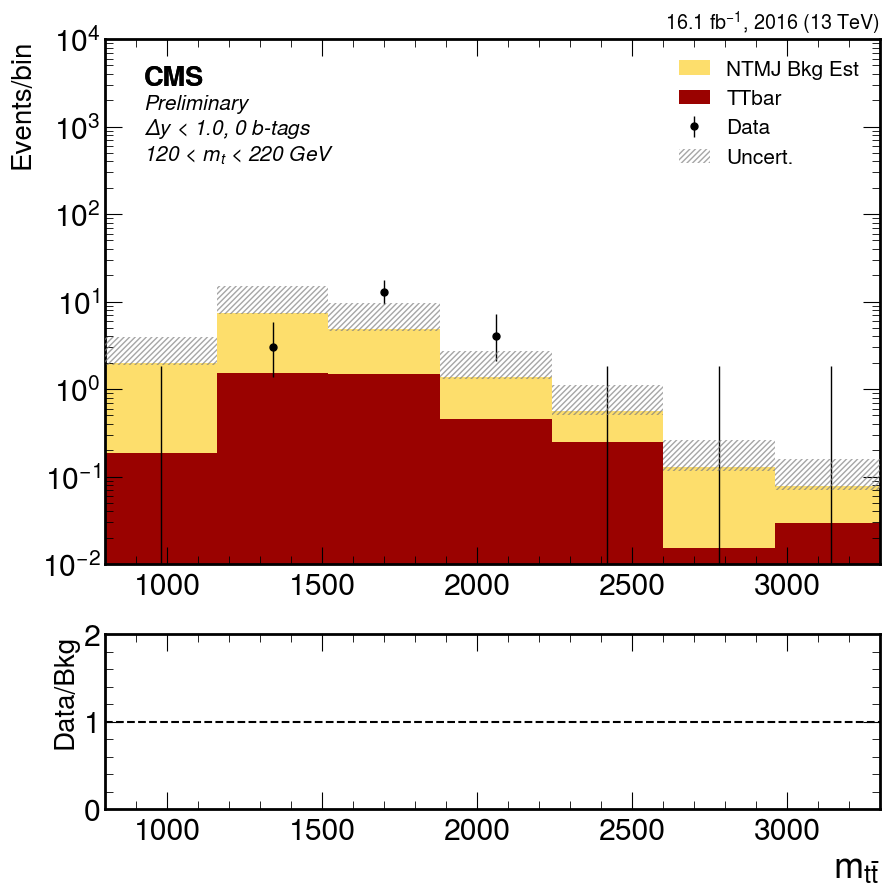

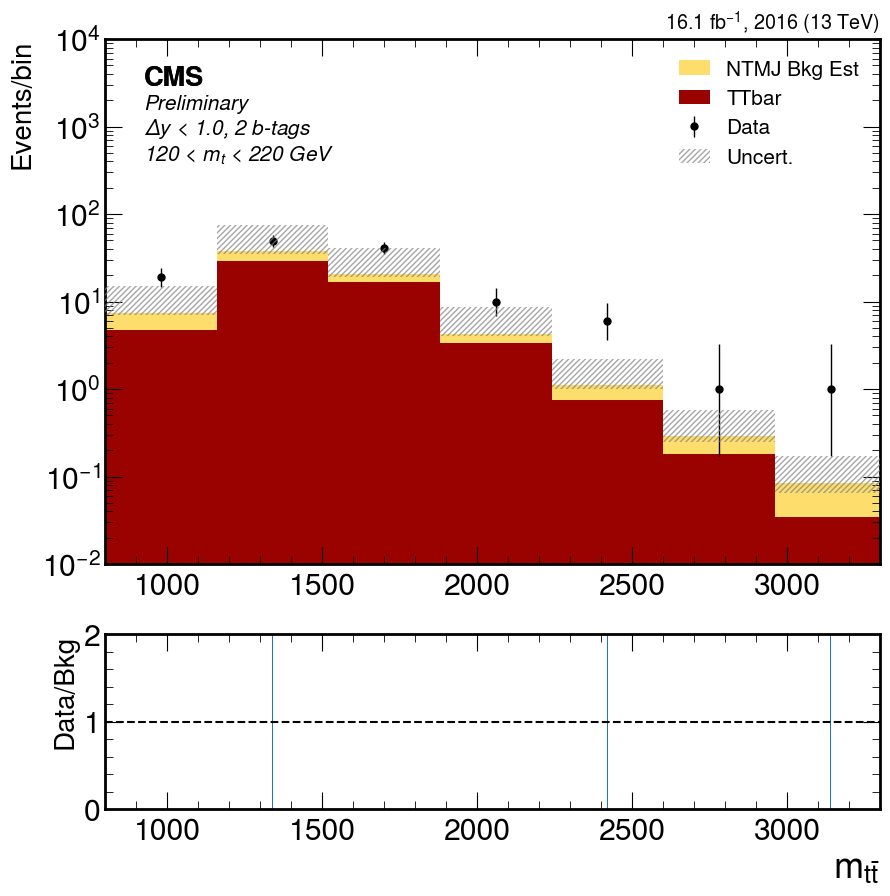

In [72]:

IOV = '2016'


qcd_hists = []
ttbar_hists = []
bkg_hists = []
data_hists = []


cats = ['0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd']
cat_labels = ['cen0b', 'fwd0b', 'cen1b', 'fwd1b', 'cen2b', 'fwd2b']

cats = [cats[0], cats[4]]
cat_labels = [cat_labels[0], cat_labels[4]]

for cat in cat_labels:
    

    fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])
    
    
    hbkg = f[f'TotalBkg_{cat}Pass_postfit_projy1;1']
    hqcd = f[f'QCD_{cat}Pass_postfit_projy1;1']
    httbar = f[f'16_TTbar_{cat}Pass_postfit_projy1;1']
    hdata = f[f'data_obs_{cat}Pass_postfit_projy1;1']
    
    bkg_hists.append(hbkg)
    qcd_hists.append(hqcd)
    ttbar_hists.append(httbar)
    data_hists.append(hdata)
    
    hep.histplot(hdata, histtype='errorbar', color='k', ax=ax1, label='Data')
    hep.histplot(hbkg, histtype='fill', 
                 color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)#, **error_opts)
    hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='TTbar', ax=ax1)
    # ax1.errorbar(hbkg.axis().centers(), hbkg.values(), yerr=hbkg.errors()*10, marker='', ls='', color='black',
    #              ecolor='lightgray', elinewidth=90, capsize=0, errorhatch='//')
    
    height = hbkg.values() + hbkg.errors()
    bottom = hbkg.values() - hbkg.errors()
    edges  = hbkg.axis().edges()
    
    ax1.bar(x = edges[:-1],
               height=height,
               bottom=bottom,
               width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
               linewidth=0, facecolor='none', alpha=0.7,
               zorder=10, label='Uncert.')

    dytext = ''
    if 'cen' in cat:
        dytext = r'$\Delta y$ < 1.0'
    elif 'fwd' in cat:
        dytext = r'$\Delta y$ > 1.0'

    btext = ''
    if '0b' in cat:
        btext = '0 b-tags'
    elif '1b' in cat:
        btext = '1 b-tag'
    elif '2b' in cat:
        btext = '2 b-tags'

    
    text = 'Preliminary'+'\n'+dytext+', '+ btext + '\n' + r'125 < $m_{t}$ < 225 GeV'
    hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi[IOV]/1000.), year=IOV, loc=2, fontsize=15, ax=ax1)
    hep.cms.text(text, loc=2, fontsize=15, ax=ax1)




    ax1.set_yscale('log')
    ax1.set_ylim(1e-2,1e4)
    ax1.set_xlim(800,3300)


    ax1.set_ylabel('Events/bin', fontsize=20)

    ratio_plot = hdata.values() / (hbkg.values() + httbar.values())
    pull = (hdata.values() - hbkg.values())/hbkg.errors()
    
#     ax2.bar(hdata.axis().centers(), pull)

    ax2.plot(hdata.axis().centers(), ratio_plot, color='k', ls='', marker='o')
    
    
    ax2.set_ylim(0,2)
    ax2.axhline(1, color='black', ls='--')
    ax2.set_ylabel('Data/Bkg', fontsize=20)
    ax2.set_xlabel(ax1.get_xlabel())
    ax2.set_xlabel(r'$m_{t\bar{t}}$')
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xlim(800,3300)

    ax1.legend(loc=1, fontsize=15)


    imagefile = f'images/png/closureTest/{IOV}/closuretest_{cat}.png'

    plt.savefig(imagefile)
    plt.savefig(imagefile.replace('png','pdf'))
    print('saving ', imagefile)
    print('saving ', imagefile.replace('png','pdf'))
    
    
    



## plot inclusive plots

saving  images/png/closureTest/2016/closuretest_inclusive_0.png
saving  images/pdf/closureTest/2016/closuretest_inclusive_0.pdf
saving  images/png/closureTest/2016/closuretest_inclusive_1.png
saving  images/pdf/closureTest/2016/closuretest_inclusive_1.pdf
saving  images/png/closureTest/2016/closuretest_inclusive_2.png
saving  images/pdf/closureTest/2016/closuretest_inclusive_2.pdf


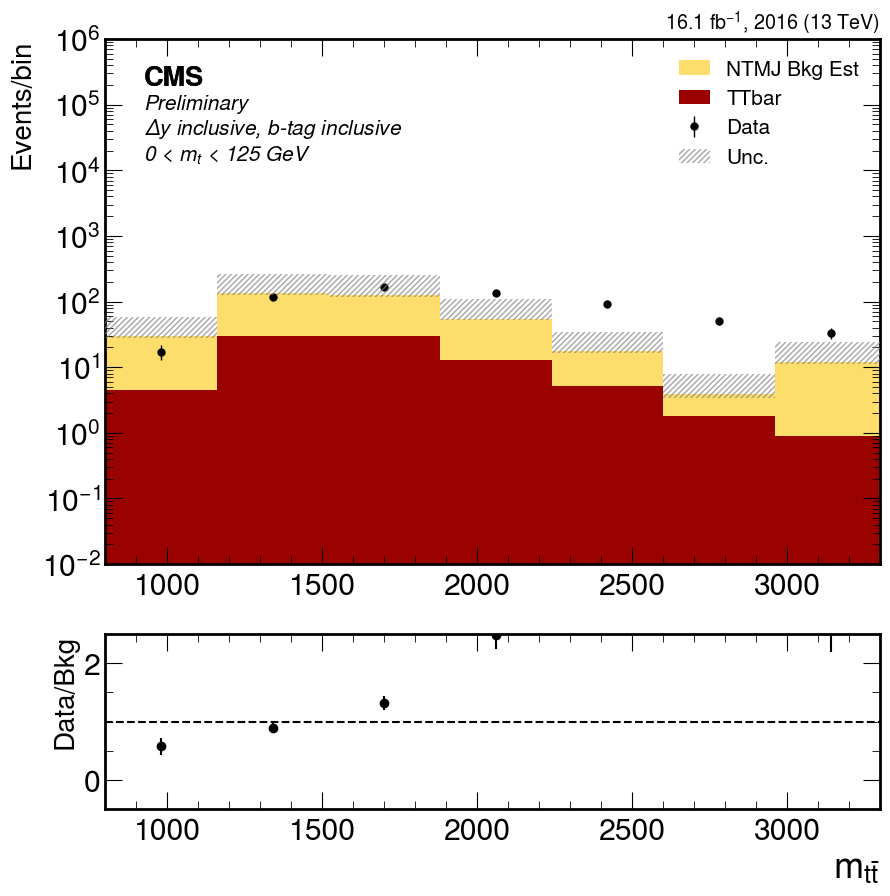

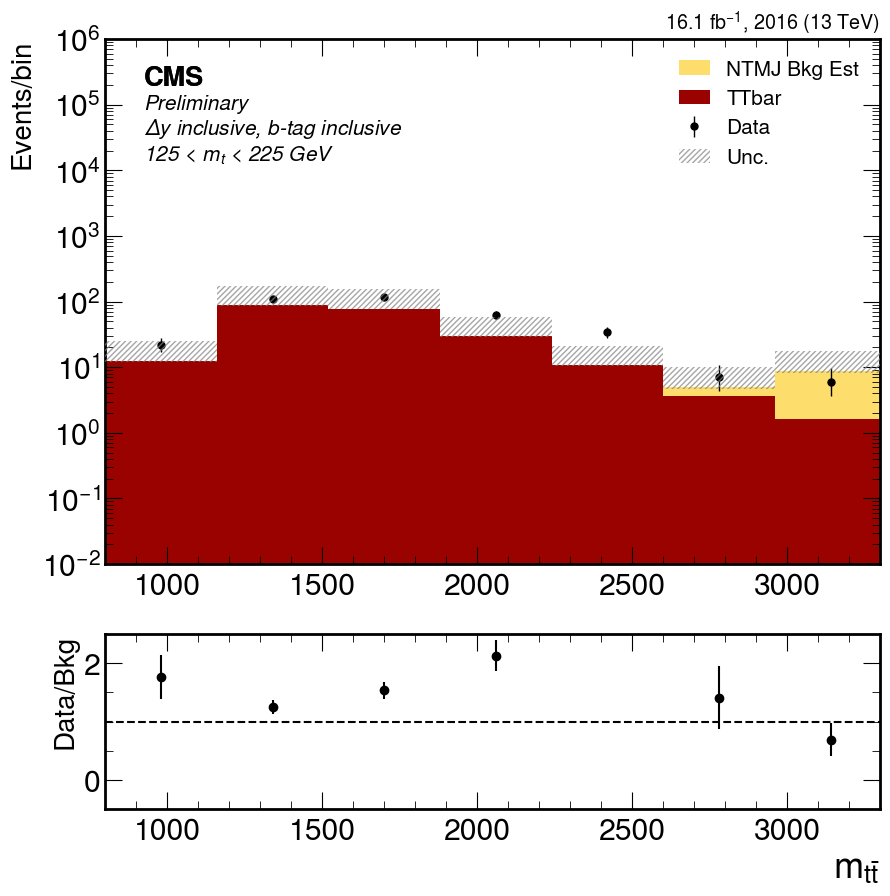

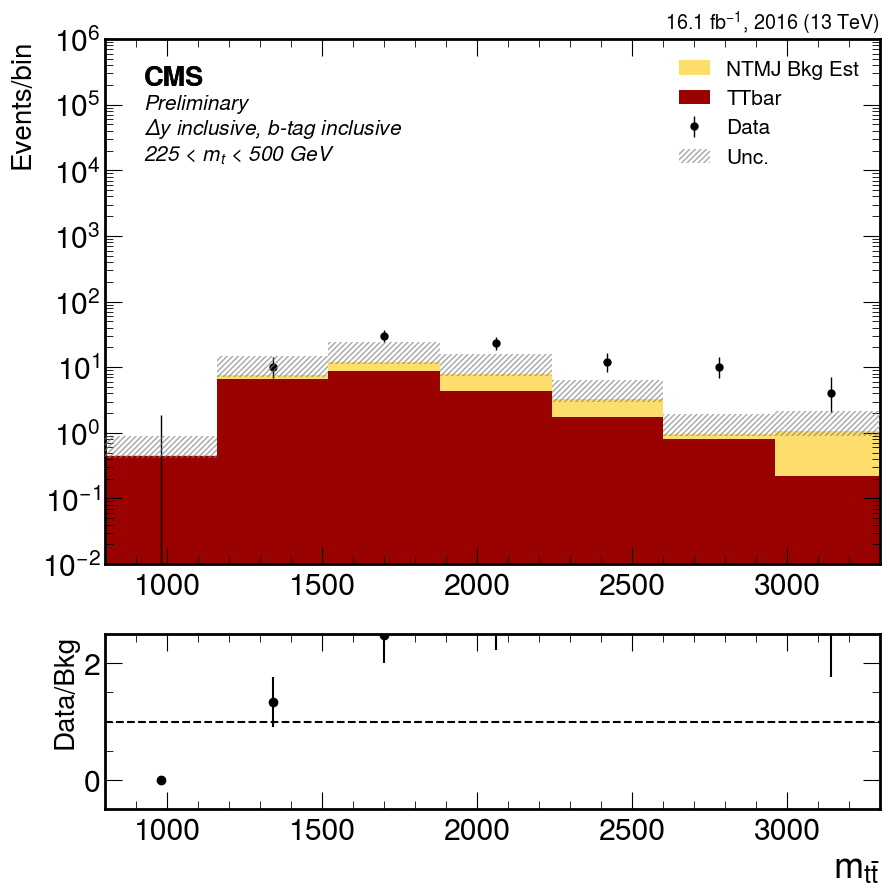

In [92]:

IOV = '2016'


qcd_hists = []
ttbar_hists = []
bkg_hists = []
data_hists = []


fname = 'all_plots_inclusive.root'
finc = uproot.open('all_plots_inclusive.root')

cats = ['0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd']
cat_labels = ['cen0b', 'fwd0b', 'cen1b', 'fwd1b', 'cen2b', 'fwd2b']

bands = [
    r'0 < $m_{t}$ < 125 GeV',
    r'125 < $m_{t}$ < 225 GeV',
    r'225 < $m_{t}$ < 500 GeV',
]

for i in range(len(bands)):

    fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

    hbkg = finc[f'TotalBkg_Pass_postfit_projy{i};1']
    hqcd = finc[f'QCD_Pass_postfit_projy{i};1']
    httbar = finc[f'16_TTbar_Pass_postfit_projy{i};1']
    hdata = finc[f'data_obs_Pass_postfit_projy{i};1']

    #     hbkg = f[f'TotalBkg_{cat}Pass_postfit_projy1;1']
    #     hqcd = f[f'QCD_{cat}Pass_postfit_projy1;1']
    #     httbar = f[f'16_TTbar_{cat}Pass_postfit_projy1;1']
    #     hdata = f[f'data_obs_{cat}Pass_postfit_projy1;1']

    #     bkg_hists.append(hbkg)
    #     qcd_hists.append(hqcd)
    #     ttbar_hists.append(httbar)
    #     data_hists.append(hdata)

    hep.histplot(hdata, histtype='errorbar', color='k', ax=ax1, label='Data')
    hep.histplot(hbkg, histtype='fill', 
                 color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)#, **error_opts)
    hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='TTbar', ax=ax1)

    height = hbkg.values() + hbkg.errors()
    bottom = hbkg.values() - hbkg.errors()
    edges  = hbkg.axis().edges()

    ax1.bar(x = edges[:-1],
               height=height,
               bottom=bottom,
               width = np.diff(edges), align='edge', hatch='//////', edgecolor='gray',
               linewidth=0, facecolor='none', alpha=0.7,
               zorder=10, label='Unc.')

    dytext = r'$\Delta y$ inclusive'
    btext = 'b-tag inclusive'


    text = 'Preliminary'+'\n'+dytext+', '+ btext + '\n' + bands[i]
    hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi[IOV]/1000.), year=IOV, loc=2, fontsize=15, ax=ax1)
    hep.cms.text(text, loc=2, fontsize=15, ax=ax1)




    ax1.set_yscale('log')
    ax1.set_ylim(1e-2,1e6)
    ax1.set_xlim(800,3300)


    ax1.set_ylabel('Events/bin', fontsize=20)
    
    x = hdata.values()
    xerr = hdata.errors()
    y = hbkg.values()
    yerr = hbkg.errors()
    
    ratio_plot = x/y
    ratio_err = np.sqrt( ( ((1/y)*xerr)**2 + ((x/y**2)*yerr)**2))
    
    
    
#     ax2.bar(x = edges[:-1],
#                height=ratio_plot+ratio_err,
#                bottom=ratio_plot-ratio_err,
#                width = np.diff(edges), align='edge', hatch='/////', edgecolor='lightgray',
#                linewidth=0, facecolor='lightgrey', alpha=0.7,
#                zorder=10, label='Unc.')
    
    


    ax2.errorbar(hdata.axis().centers(), ratio_plot, yerr=ratio_err, color='k', ls='', marker='o')


    ax2.set_ylim(-0.5,2.5)
    ax2.axhline(1, color='black', ls='--')
    ax2.set_ylabel('Data/Bkg', fontsize=20)
    ax2.set_xlabel(ax1.get_xlabel())
    ax2.set_xlabel(r'$m_{t\bar{t}}$')
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xlim(800,3300)

    ax1.legend(loc=1, fontsize=15)


    imagefile = f'images/png/closureTest/{IOV}/closuretest_inclusive_{i}.png'

    plt.savefig(imagefile)
    plt.savefig(imagefile.replace('png','pdf'))
    print('saving ', imagefile)
    print('saving ', imagefile.replace('png','pdf'))






In [85]:
np.diff(edges)/10

array([36., 36., 36., 36., 36., 36., 36., 36.])

In [88]:
ratio_err

array([ 0.        ,  4.24851261, 13.81834597, 14.00992135, 12.8478141 ,
       33.09922194,  7.52687552,  0.89669935])

In [65]:
hbkg.axis().edges()

array([ 800., 1160., 1520., 1880., 2240., 2600., 2960., 3320., 3680.])

In [25]:
width = hdata.axis().width
xvals1 = []
xvals2 = []
xvals = []
for center in hdata.axis().centers():
    xvals1.append(center - width)
    xvals2.append(center + width)
    xvals.append([center - width, center+width])

AttributeError: 'Hist' object has no attribute 'axis'

In [26]:
np.r_[[2],[3]]

array([2, 3])

In [27]:
hqcd.errors()

AttributeError: 'Hist' object has no attribute 'errors'

In [28]:
yvals1 = hqcd.values() - hqcd.errors()
yvals2 = hqcd.values() + hqcd.errors()

AttributeError: 'Hist' object has no attribute 'errors'

KeyInFileError: not found: 'TotalBkg_Pass_postfit_projy1' with cycle 1

    Available keys: (none!)

in file all_plots.root

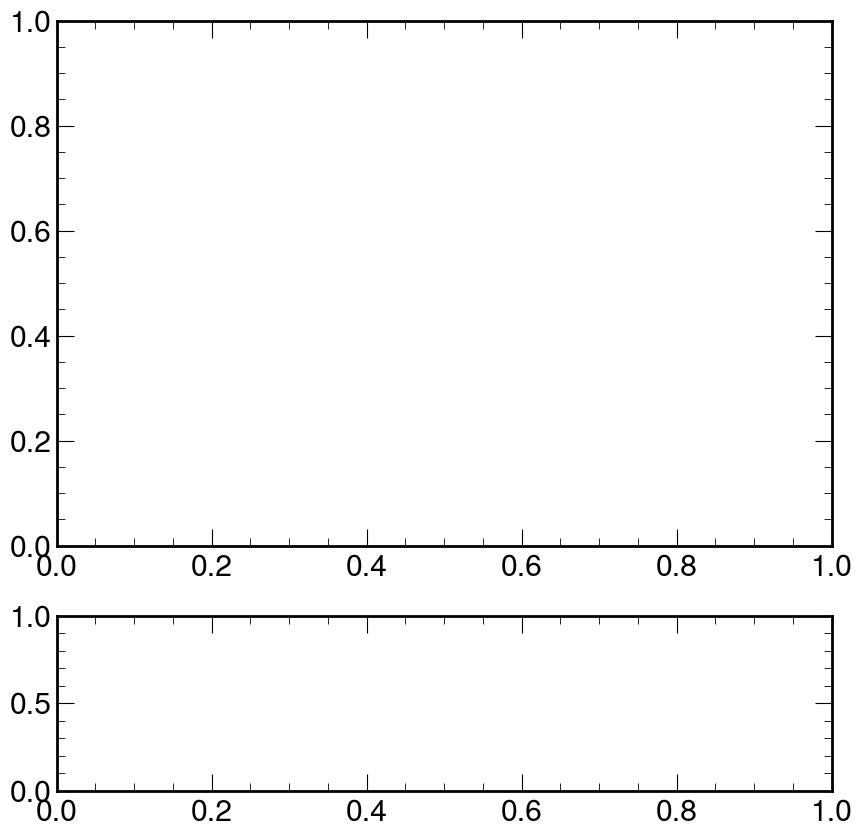

In [29]:

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

IOV = '2016'


textfontsize = 15


# hqcd = f['QCD_Pass_postfit_projy1;1']
hqcd = f['TotalBkg_Pass_postfit_projy1;1']

httbar = f['16_TTbar_Pass_postfit_projy1;1']
hdata = f['data_obs_Pass_postfit_projy1;1']


hep.histplot(hqcd, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='TTbar', ax=ax1)
hep.histplot(hdata, histtype='errorbar', color='k', ax=ax1, label='Data')



text = 'Preliminary'+'\n'+r'$\Delta y$ inclusive'+', '+r'b tag inclusive'+ '\n' + r'125 < $m_{t}$ < 225 GeV'
hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi['2016']/1000.), year='2016', loc=2, fontsize=textfontsize, ax=ax1)
hep.cms.text(text, loc=2, fontsize=textfontsize, ax=ax1)




ax1.set_yscale('log')
ax1.set_ylim(1e-3,1e4)
ax1.set_xlim(800,3700)


ax1.set_ylabel('Events/bin', fontsize=20)

bkg_vals = (hqcd.values() + httbar.values())

ratio_plot = hdata.values() / bkg_vals
ratio_err = (ratio_plot)**2 * (1/hdata.values() + 1/bkg_vals)


print(ratio_plot)

ax2.errorbar(hdata.axis().centers(), ratio_plot, yerr=ratio_err, color='k', ls='', marker='o')

ax2.fill_between(hdata.axis().centers(), -1*hqcd.errors()/hqcd.values(), hqcd.errors()/hqcd.values(), color='lightgrey')

ax2.set_ylim(0,3)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg', fontsize=20)
ax2.set_xlabel(ax1.get_xlabel())
ax2.set_xlabel(r'$m_{t\bar{t}}$')
ax2.set_xticks(ax1.get_xticks())
ax2.set_xlim(800,3700)

ax1.legend(loc=1, fontsize=textfontsize)


plt.show()

# imagefile = f'images/png/closureTest/{IOV}/closuretest_inclusive.png'

# plt.savefig(imagefile)
# plt.savefig(imagefile.replace('png','pdf'))
# print('saving ', imagefile)
# print('saving ', imagefile.replace('png','pdf'))



In [ ]:
hdata.errors()

In [ ]:
hqcd.errors()

In [ ]:
(hdata.values() - hqcd.values())/hdata.errors()

## Nuiscance Parameters

In [30]:
print("""
name                                                 pre fit                        b-only fit                           s+b fit         rho  approx impact
ttbar_xsec                                   0.000000 +/- 1.000000    +12.93 +/- 0.00 (+12.93sig, 0.00)    !+3.94 +/- 0.81 (+3.94sig, 0.81)!     !-0.80!      -0.136
lumi                                         0.000000 +/- 1.000000    +1.27 +/- 0.00 (+1.27sig, 0.00)    !+0.39 +/- 1.01 (+0.39sig, 1.01)!       -0.07      -0.015
jer                                          0.000000 +/- 1.000000    +0.04 +/- 0.00 (+0.04sig, 0.00)    !+0.04 +/- 0.07 (+0.04sig, 0.07)!     !-0.02!      -0.000
pileup                                       0.000000 +/- 1.000000    -0.29 +/- 0.00 (-0.29sig, 0.00)    !+0.03 +/- 0.85 (+0.03sig, 0.85)!       +0.01      +0.002
pdf                                          0.000000 +/- 1.000000    -1.38 +/- 0.00 (-1.38sig, 0.00)    !-0.10 +/- 1.28 (-0.10sig, 1.28)!       -0.01      -0.003
jes                                          0.000000 +/- 1.000000    +0.91 +/- 0.00 (+0.91sig, 0.00)    !+0.20 +/- 0.25 (+0.20sig, 0.25)! 
""")
      
      


name                                                 pre fit                        b-only fit                           s+b fit         rho  approx impact
ttbar_xsec                                   0.000000 +/- 1.000000    +12.93 +/- 0.00 (+12.93sig, 0.00)    !+3.94 +/- 0.81 (+3.94sig, 0.81)!     !-0.80!      -0.136
lumi                                         0.000000 +/- 1.000000    +1.27 +/- 0.00 (+1.27sig, 0.00)    !+0.39 +/- 1.01 (+0.39sig, 1.01)!       -0.07      -0.015
jer                                          0.000000 +/- 1.000000    +0.04 +/- 0.00 (+0.04sig, 0.00)    !+0.04 +/- 0.07 (+0.04sig, 0.07)!     !-0.02!      -0.000
pileup                                       0.000000 +/- 1.000000    -0.29 +/- 0.00 (-0.29sig, 0.00)    !+0.03 +/- 0.85 (+0.03sig, 0.85)!       +0.01      +0.002
pdf                                          0.000000 +/- 1.000000    -1.38 +/- 0.00 (-1.38sig, 0.00)    !-0.10 +/- 1.28 (-0.10sig, 1.28)!       -0.01      -0.003
jes                       

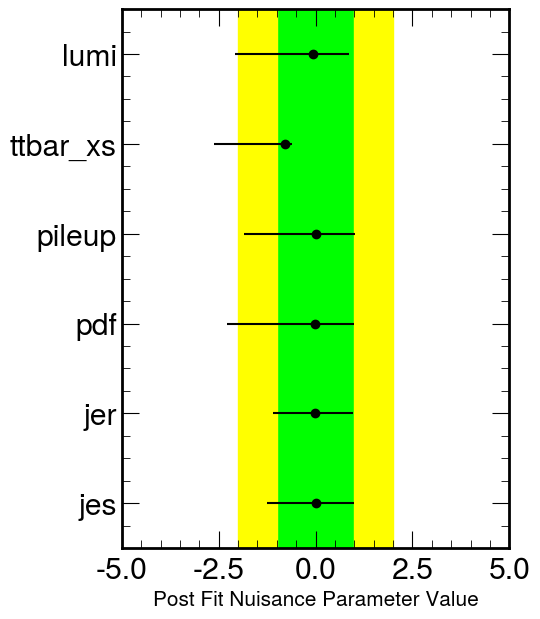

In [31]:
fig, ax1 = plt.subplots(figsize=(5,7))


ymax = ax1.get_ylim()[1]
ymin = ax1.get_ylim()[0]


ax1.fill_between([-1, 1], [-1, -1], [2*ymax, 2*ymax], color='lime')
ax1.fill_between([-2, -1], [-1, -1], [2*ymax, 2*ymax], color='yellow')
ax1.fill_between([1, 2], [-1, -1], [2*ymax, 2*ymax], color='yellow')
ax1.set_xlim(-5,5)
ax1.set_ylim(-.1, ymax*1.1)



yticks = np.linspace(ymin, ymax, 6)
ylabs = ['jes', 'jer', 'pdf', 'pileup', 'ttbar_xs', 'lumi']


errs = {
    'jes':      [ 0.00,  0.25,  0.00],
    'jer':      [-0.02,  0.07, -0.02],
    'pdf':      [-0.01,  1.28, -0.01],
    'pileup':   [ 0.01,  0.85,  0.01],
    'ttbar_xs': [-0.80,  0.81, -0.80],
    'lumi':     [-0.07,  1.01, -0.07],
    
}

ax1.errorbar(errs[ylabs[0]][0], yticks[0], xerr=1+np.array([errs[ylabs[0]][1:]]).T, marker='o', color='k')
ax1.errorbar(errs[ylabs[1]][0], yticks[1], xerr=1+np.array([errs[ylabs[1]][1:]]).T, marker='o', color='k')
ax1.errorbar(errs[ylabs[2]][0], yticks[2], xerr=1+np.array([errs[ylabs[2]][1:]]).T, marker='o', color='k')
ax1.errorbar(errs[ylabs[3]][0], yticks[3], xerr=1+np.array([errs[ylabs[3]][1:]]).T, marker='o', color='k')
ax1.errorbar(errs[ylabs[4]][0], yticks[4], xerr=1+np.array([errs[ylabs[4]][1:]]).T, marker='o', color='k')
ax1.errorbar(errs[ylabs[5]][0], yticks[5], xerr=1+np.array([errs[ylabs[5]][1:]]).T, marker='o', color='k')


ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabs)

ax1.set_xlabel('Post Fit Nuisance Parameter Value', fontsize=15, loc='center')

plt.savefig('images/nuisance.pdf')
plt.savefig('images/nuisance.png')

In [32]:
ax1.get_ylim()[1]

1.1

In [33]:
with open('nus.txt', 'r') as f:
    
    for line in f.readlines():
        print(line.split('\t').split('\t'))


AttributeError: 'list' object has no attribute 'split'

In [37]:
string = '''
\\begin{figure}[!htbp]
\\begin{center}
\\includegraphics[width=0.6\\linewidth]{'FILENAME'}
\\caption{CAPTION}
\\label{LABEL}
\\end{center}
\\end{figure}
'''

In [38]:
string

"\n\\begin{figure}[!htbp]\n\\begin{center}\n\\includegraphics[width=0.6\\linewidth]{'FILENAME'}\n\\caption{CAPTION}\n\\label{LABEL}\n\\end{center}\n\\end{figure}\n"

In [39]:
for img in os.lsdir('images')

SyntaxError: invalid syntax (425001229.py, line 1)

In [40]:
head = 'images/pdf/'
types = os.listdir(head)


for t in types:
    
    if 'systematic' in t: continue
    years = os.listdir(head+t+'/')
    
    for y in years:
        files = os.listdir(head+t+'/'+y)
        for file in files:
            
            filename = 'Plots/'+t+'/'+y+'/'+file
   
            
            label = filename.replace(head+t+'/'+y+'/', '').replace('.pdf', '')
            caption = label.replace('_', ' ')

            
            newstring = string.replace('FILENAME', filename).replace('CAPTION', caption).replace('LABEL', label)
            print(newstring)
            
            




\begin{figure}[!htbp]
\begin{center}
\includegraphics[width=0.6\linewidth]{'Plots/closureTest/2016all/closuretest_inclusive_deepak8.pdf'}
\caption{Plots/closureTest/2016all/closuretest inclusive deepak8}
\label{Plots/closureTest/2016all/closuretest_inclusive_deepak8}
\end{center}
\end{figure}


\begin{figure}[!htbp]
\begin{center}
\includegraphics[width=0.6\linewidth]{'Plots/closureTest/2016all/closuretest_0bcen_deepak8.pdf'}
\caption{Plots/closureTest/2016all/closuretest 0bcen deepak8}
\label{Plots/closureTest/2016all/closuretest_0bcen_deepak8}
\end{center}
\end{figure}


\begin{figure}[!htbp]
\begin{center}
\includegraphics[width=0.6\linewidth]{'Plots/closureTest/2016all/closuretest_0bfwd_deepak8.pdf'}
\caption{Plots/closureTest/2016all/closuretest 0bfwd deepak8}
\label{Plots/closureTest/2016all/closuretest_0bfwd_deepak8}
\end{center}
\end{figure}


\begin{figure}[!htbp]
\begin{center}
\includegraphics[width=0.6\linewidth]{'Plots/closureTest/2016all/closuretest_1bcen_deepak8.pdf'}
\